In [1]:
import time
def timer(func):
  def wrapper(*args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    computation_time = end_time - start_time
    print(f"Executation time of {func.__name__}: {computation_time} seconds")
    return result
  return wrapper

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
# Hyperparameter 설정
lr = 0.1
epochs = 100
min_batch = 5 # 들어갈 그림의 수

Files already downloaded and verified
Files already downloaded and verified


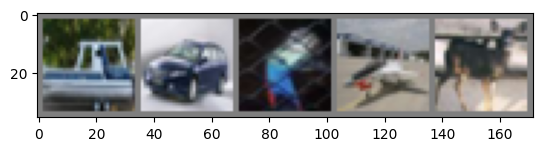

tensor(8) tensor(1) tensor(2) tensor(0) tensor(4)


In [8]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define a transformation to preprocess the data (e.g., normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 이미지 데이터를 정규화(normalize)하는 작업.
              # mean_channels는 각 채널(RGB 등)의 평균값이고, stddev_channels는 각 채널의 표준편차
              # 각 채널의 평균은 0.5로, 표준편차는 0.5로 만들어집니다. 이는 픽셀 값들이 0과 1 사이의 범위로 조절
])

# Download and load the CIFAR-10 training dataset
train_dataset = CIFAR10(".", train=True, download=True, transform=transform)
test_dataset = CIFAR10(".", train=False, download=True, transform=transform)

# Create a DataLoader for the training dataset
train_loader = DataLoader(dataset=train_dataset, batch_size=min_batch, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=min_batch, shuffle=False)


In [17]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

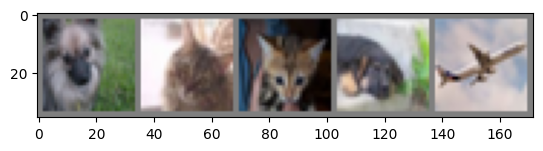

  dog   cat   cat   dog plane


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate over the DataLoader to get batches of data
for images, labels in train_loader:
    # Show images
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(5)))
    break  # Display only the first batch

In [21]:
class DeepClassification(nn.Module) :
  def __init__ (self, hidden_variables=[128, 64, 10], input_output_dim=(32*32*3, 10)) :
    super().__init__()
    self.input_variable_dim = input_output_dim[0]
    self.output_variable_dim = input_output_dim[1]
    self.list_hidden_variable = hidden_variables
    self.layer = nn.Sequential()

    variable_dim = self.input_variable_dim
    for i, hidden_variable in enumerate(self.list_hidden_variable) :
      self.layer.add_module('layer_' + str(i), nn.Linear(variable_dim, hidden_variable))
      self.layer.add_module('custom_activation_'+str(i), nn.ReLU())
      variable_dim = hidden_variable
    self.layer.add_module('dropout_' + str(i), nn.Dropout(0.1))
    self.layer.add_module('final_layer', nn.Linear(variable_dim, self.output_variable_dim))

  def forward(self, x) :
    x = x.view(-1, self.input_variable_dim) # 이거 바꾸라고 했는데 ... 일단 고
    y_hat = self.layer(x)
    return y_hat

In [22]:
def make_train_step(model, loss_fn, optimizer):
  def train_step_fn(x, y):
    model.train() # 모델을 학습모드로 전환
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item()
  return train_step_fn

In [45]:
@timer
def train_model_classification(epochs=1000, eval_test_accuracy=False):
  train_losses = []

  for epoch in range(epochs):
    mini_batch_losses = []
    for x_minibatch, y_minibatch in train_loader:
      x_minibatch = x_minibatch.to(device)
      y_minibatch = y_minibatch.to(device)
      mini_batch_loss = train_step(x_minibatch, y_minibatch)
      mini_batch_losses.append(mini_batch_loss)

    if (epoch + 1) % 5 == 0:
      loss = np.mean(mini_batch_losses)
      print("train loss at {} epoch {}".format(epoch + 1, round(loss, 10)))
      train_losses.append(loss)

  model.eval()
  correct_predictions = 0
  total_samples = 0

  for _ in range(5):
    for x_minibatch, y_minibatch in test_loader:
      x_minibatch = x_minibatch.to(device)
      y_minibatch = y_minibatch.to(device)
      y_hat = model(x_minibatch)
      _, predicted_labels = torch.max(y_hat, 1)
      correct_predictions += (predicted_labels == y_minibatch).sum().item()
      total_samples += y_minibatch.size(0)
  accuracy = correct_predictions / total_samples
  print("테스트 정확도: ", accuracy)

  return train_losses


In [46]:
model = DeepClassification().to(device) # model을 GPU로 보내기
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # SGD 보다 Adam으로 하면 성능이 훨씬 좋아짐
train_step = make_train_step(model, loss_fn, optimizer)
train_loss = train_model_classification(epochs=2, eval_test_accuracy=True)

테스트 정확도:  0.4552
Executation time of train_model_classification: 84.69530987739563 seconds


## 공식문서 참고

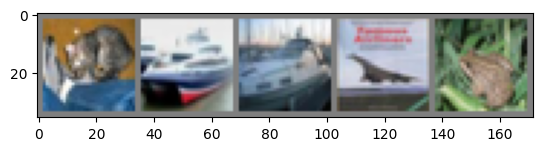

GroundTruth:  cat   ship  ship  plane frog 


In [34]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [35]:
images = images.to(device)
outputs = model(images)

In [36]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))

Predicted:  cat   ship  ship  plane frog 


In [43]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 45 %


In [44]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 48.2 %
Accuracy for class: car   is 48.7 %
Accuracy for class: bird  is 24.7 %
Accuracy for class: cat   is 19.0 %
Accuracy for class: deer  is 25.4 %
Accuracy for class: dog   is 47.3 %
Accuracy for class: frog  is 66.9 %
Accuracy for class: horse is 53.6 %
Accuracy for class: ship  is 71.8 %
Accuracy for class: truck is 47.2 %
